#1.Importing Libraries


In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aparpokhrel
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:48<00:00, 51.0MB/s]


In [3]:
from pathlib import Path

In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow  as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import load_model
import cv2

#2.Data preprocessing

In [5]:
labels = [ 'PNEUMONIA','NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
train = get_training_data('/content/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('/content/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('/content/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


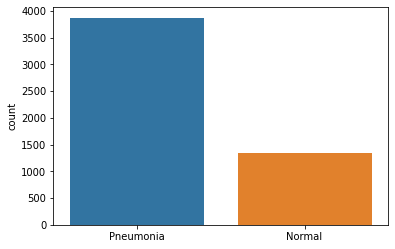

In [7]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(l)

In [8]:
train_dir = Path('/content/chest-xray-pneumonia/chest_xray/chest_xray/train')

normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_imgs = normal_cases_dir.glob('*.jpeg')
pneumonia_imgs = pneumonia_cases_dir.glob('*.jpeg')

train_dt = []

for img in normal_imgs:
  train_dt.append((img,0))

for img in pneumonia_imgs:
  train_dt.append((img,1))

train_dt = pd.DataFrame(train_dt, columns =['Image', 'Label'], index= None)

train_dt= train_dt.sample(frac=1.).reset_index(drop=True)

train_dt.head()


,Image,Label
0,/content/chest-xray-pneumonia/chest_xray/chest...,1
1,/content/chest-xray-pneumonia/chest_xray/chest...,1
2,/content/chest-xray-pneumonia/chest_xray/chest...,1
3,/content/chest-xray-pneumonia/chest_xray/chest...,1
4,/content/chest-xray-pneumonia/chest_xray/chest...,1


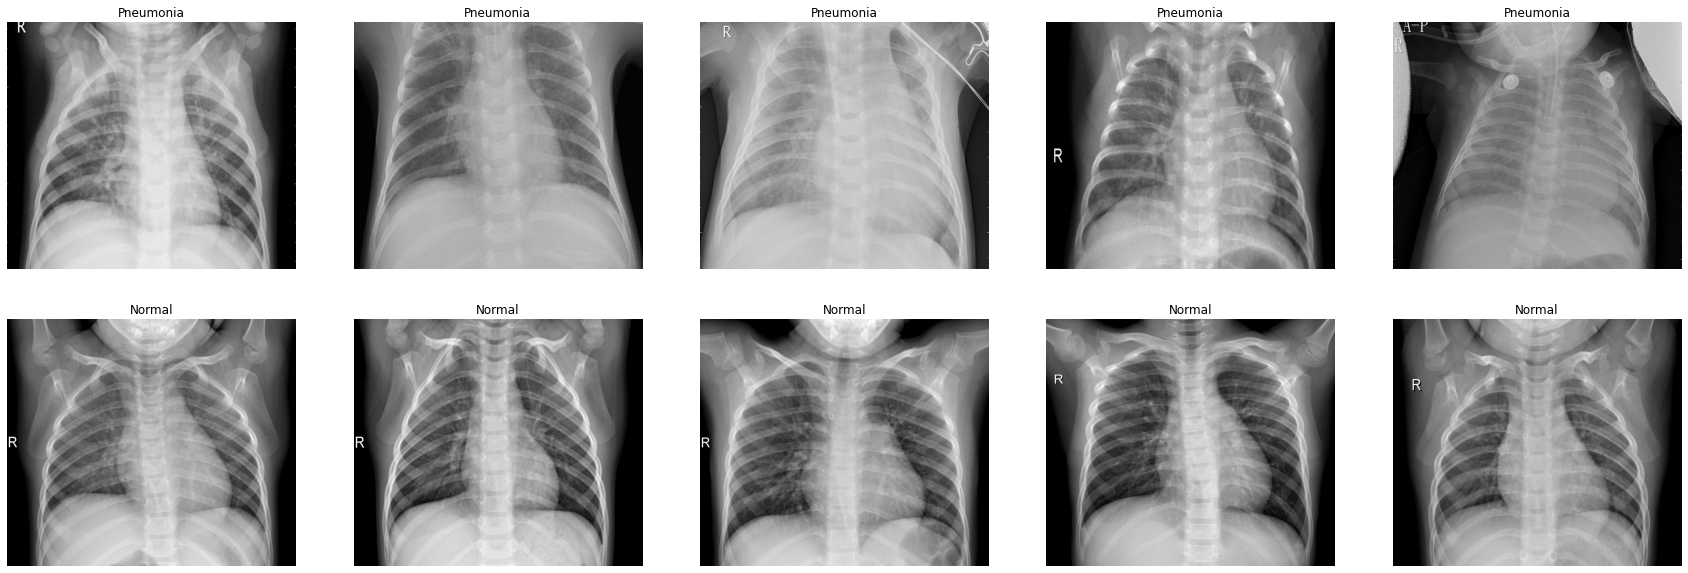

In [9]:
pneumonia_samples = (train_dt[train_dt['Label']==1]['Image'].iloc[:5]).tolist()
normal_samples = (train_dt[train_dt['Label']==0]['Image'].iloc[:5]).tolist()


samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

##2.1 Splitting x and y labels of training, validation, and test dataset



In [10]:
x_train, y_train = [], []
x_test, y_test = [], []
x_val, y_val = [], []


for fts, label in train:
  x_train.append(fts)
  y_train.append(label)

for fts, label in test:
  x_test.append(fts)
  y_test.append(label)

for fts, label in val:
  x_val.append(fts)
  y_val.append(label)



##2.2 Grayscale normalization

In [11]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255



##2.3 Resizing data 

In [12]:

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

#3.Data augmentation

In [13]:


datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30, 
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip = True,  
        vertical_flip=False)  


In [14]:
datagen.fit(x_train)

#4.Training Model

In [15]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

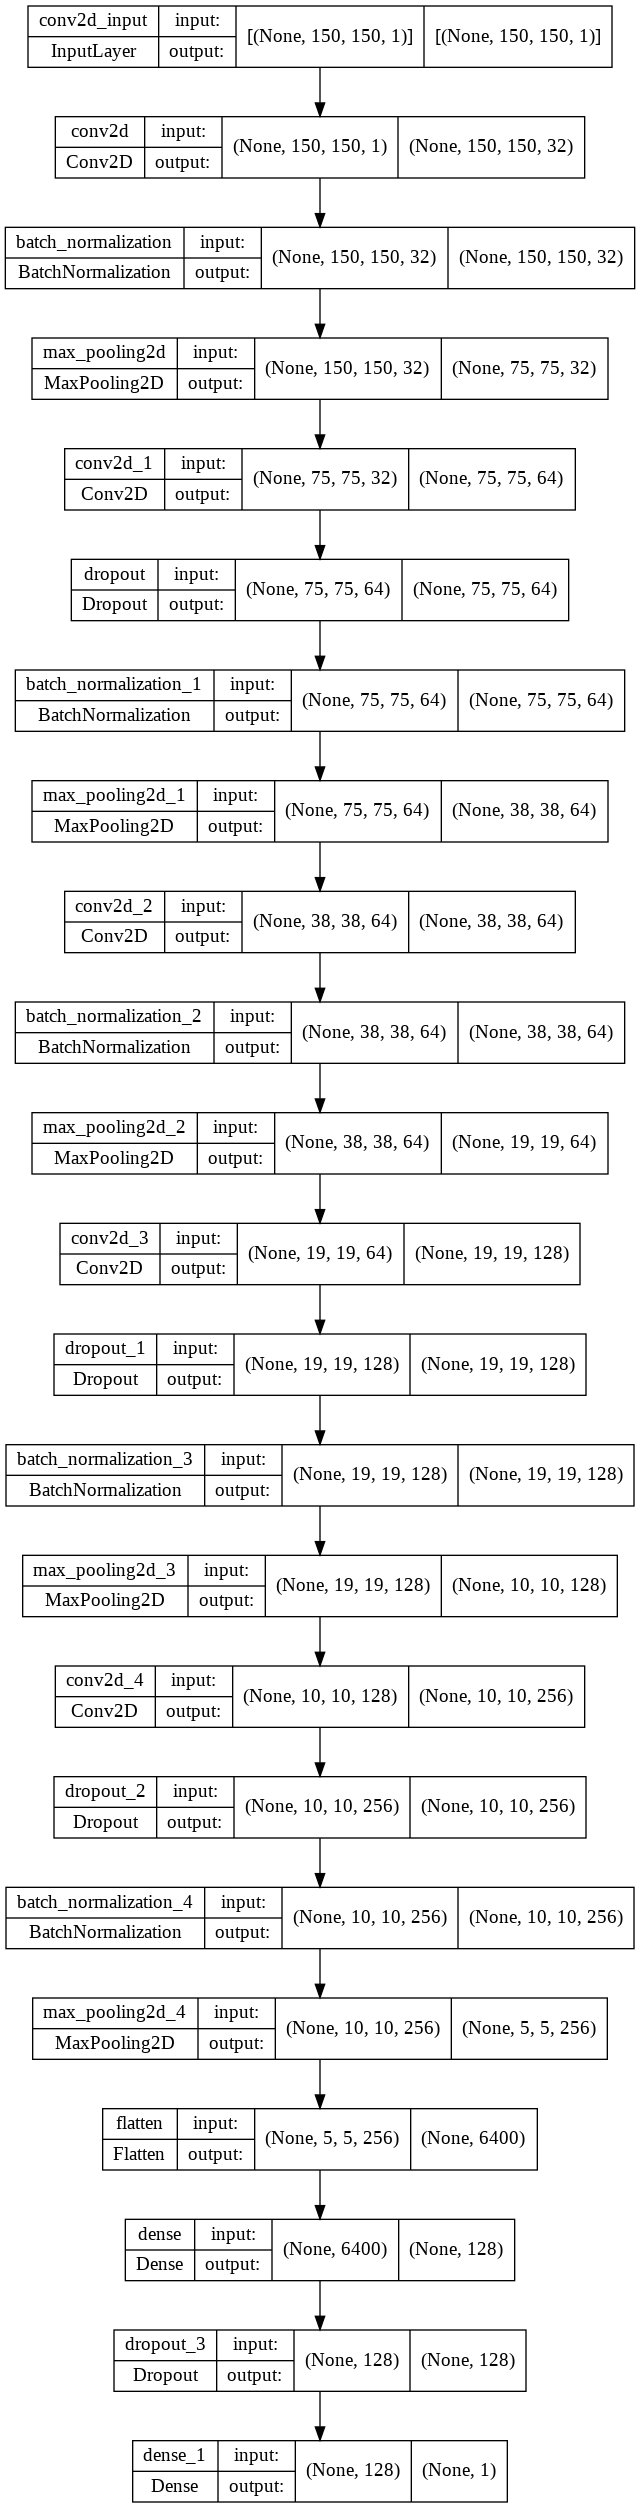

In [16]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=96)

In [17]:
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [18]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 30,
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [lrr])

Epoch 1/30
163/163 [==============================] - 24s 70ms/step - loss: 0.6718 - accuracy: 0.8365 - val_loss: 33.1533 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 11s 68ms/step - loss: 0.2860 - accuracy: 0.8978 - val_loss: 62.3455 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9128
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 11s 67ms/step - loss: 0.2466 - accuracy: 0.9128 - val_loss: 20.6983 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 11s 67ms/step - loss: 0.1573 - accuracy: 0.9438 - val_loss: 25.7061 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 11s 67ms/step - loss: 0.1383 - accuracy: 0.9505 - val_loss: 0.3949 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 6/30
163/163 [======================

##4.1Model Metrics and Analysis

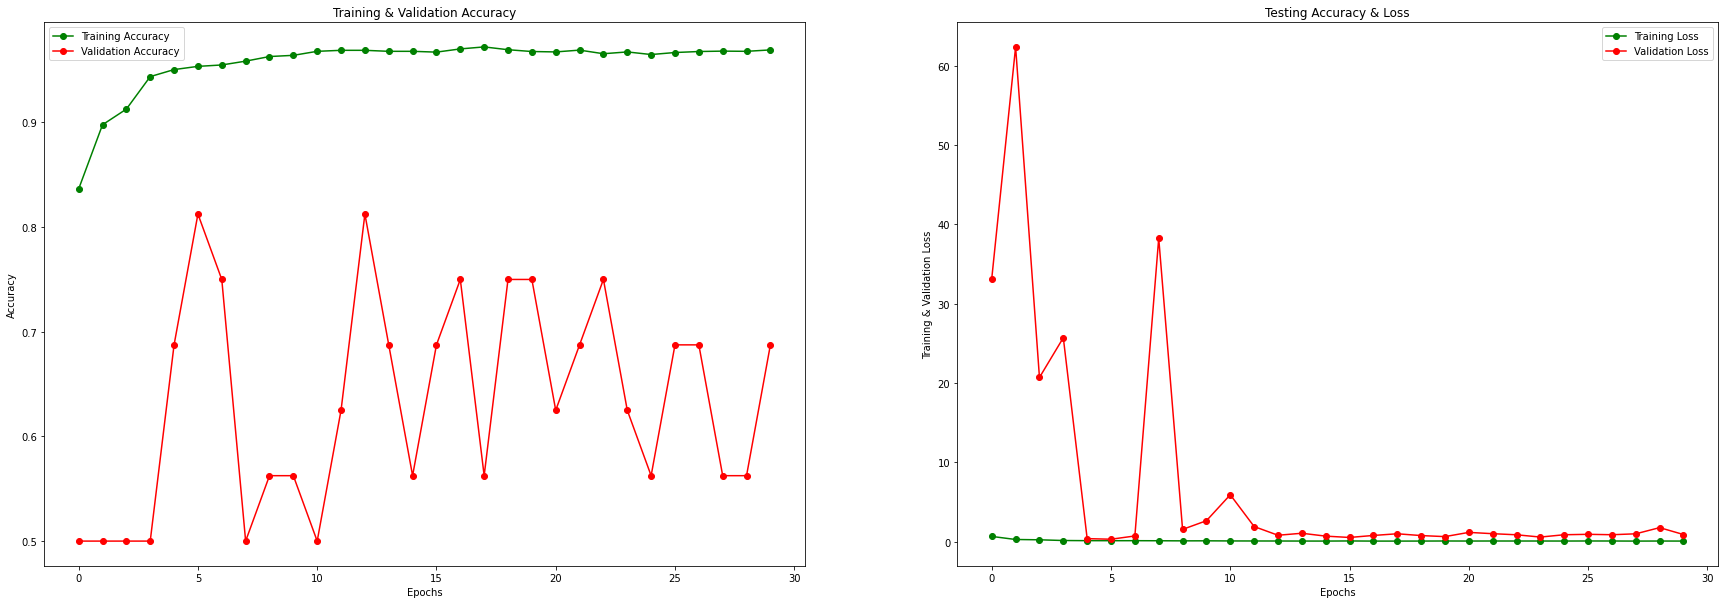

In [19]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(30,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

##4.2 Testing dataset

In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 13ms/step - loss: 0.2787 - accuracy: 0.9119
Loss of the model is -  0.2787318527698517
20/20 [==============================] - 0s 13ms/step - loss: 0.2787 - accuracy: 0.9119
Accuracy of the model is -  91.18589758872986 %


In [21]:
predictions = model.predict(x_test) 
for i in range(len(predictions)): 
    predictions[i] = 1 if predictions[i]>0.5 else 0

In [22]:
print(classification_report(y_test, 
                            predictions, 
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.92      0.93       390
   Normal (Class 1)       0.87      0.89      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.91      0.91       624
       weighted avg       0.91      0.91      0.91       624



In [23]:
cMatrix= confusion_matrix(y_test,predictions)
cMatrix = pd.DataFrame(cMatrix , index = ['0','1'] , columns = ['0','1'])
cMatrix

,0,1
0,360,30
1,25,209


In [24]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

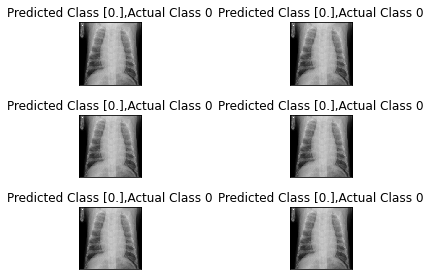

In [25]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

#5.Predictions

##5.1Predicting a random image

In [26]:
f_resize = lambda x: np.array(x).reshape(-1, 150, 150, 1)
def pneumoniaPrediction(img):
    img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resize_img = cv2.resize(img_array, (150,150))
    resize_img = np.array(resize_img) / 255.0
    resize_img = f_resize(resize_img)

    isPneumonic = model.predict(resize_img)

    return isPneumonic

In [29]:
img = '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'

isPneumonic = pneumoniaPrediction(img)


result = 'Normal' if isPneumonic[0] > 0.5 else "Pneumonia"

print(result)


Pneumonia


##5.2 Saving the model

In [27]:
model.save('x-ray_model')


In [32]:
model = load_model('/content/x-ray_model')
print(model)

In [66]:
model.save_weights('x-ray_model.weights.h5')